# 神经网络

## 人工神经元

深度学习的核心是神经网络：一种能通过简单函数的组合来表示复杂函数的数学实体。这些复杂函数的基本构件是神经元，如 `o = tanh(w * x + b)` 。其核心就是输入的线性变换（例如，将输入乘以一个数字【权重】，加上一个常数【偏置】），然后应用一个固定的非线性函数，即激活函数。从数学上讲，我们可以把这个写成 `o = f(w * x + b)` ，其中 `x` 是输入， `w` 是权重或比例因子， `b` 是偏置或偏移量， `f` 是激活函数。通常， `x` 和 `o` 可以是简单的标量或向量值（意思是保留许多标量值）。类似地， `w` 可以是单个标量或矩阵，而 `b` 是标量或向量（输入的维度和权重必须匹配）。在后一种的情况下，前面的表达式被称为神经元，因为它通过多维权重和偏置来表示许多神经元。

### 组成一个多层网络

一个多层的神经网络就由上面讨论的函数组成：

```
x_1 = f(w_0 * x + b_0)
x_2 = f(w_1 * x_1 + b_1)
...
y = f(w_n * x_n + b_n)
```
其中前一层神经元的输出被用作后一层神经元的输入。需要注意到的是 `w_0` 是一个矩阵，而 `x` 是一个向量，使用向量可以让 `w_0` 承载整个神经元层，而不是单一的权重。

### 激活函数

**激活函数** 有两个重要作用：
    
    1. 在模型内部，它允许输出函数在不同值上有不同的斜率，这是线性函数无法做到的。通过巧妙的为许多输入设置不同的斜率，神经网络可以近似任意函数。
    2. 在网络的最后一层，它的作用是将前面的线性运算输出集中到给定的范围内。
    
现在先讨论第二个作用是什么意思。假设我们正在给图像分配一个好狗狗分数，那么德牧和西班牙猎犬的图片应该得分很高，而飞机和垃圾车的得分应该很低，熊的图片得分应该也很低，虽然比垃圾车得分高。现在存在的问题是：我们必须定义一个“高分”，这意味着我们需要处理所有的 `float32` 范围，因为可能会得到相当高的分数。即使我们定义了一个十分制的量表，任然存在得分超过10分的情况，因为本质上它都是 `w * x + b` 的值，这样的函数不会自然的限定到特定的输出范围内。

最终我们希望将线性操作的输出严格的控制在一个特定的范围内，这样输出的接受者就能更好的处理接下来的操作。

对于上面问题的解决方案，一种可能是对输出值设置上限：低于 0 的值设为 0 ，高于 10 的值设为 10 。这涉及一个叫做 `torch.nn.Hardtanh()` 的激活函数（默认范围为 -1 到 1），下面是这个激活函数的图像：

![](data/images/Hardtanh.png)

另一类运行良好的函数是 `torch.nn.Sigmoid()` ，包括 `1 / (1 + e ** -x)` 、`torch.tanh()` 等。这些函数的曲线在 `x` 趋于负无穷大是逐渐接近 0 或 -1 ，在 `x==0` 时具有基本恒定的斜率。

一般来说激活函数有如下特性（在特定条件下可能是错误的）：

    * 激活函数是非线性的，非线性使得整个网络能够逼近更复杂的函数。
    * 激活函数是可微的，因此可以通过他们计算梯度。

没有这些特性，网络要么退回线性模型，要么就变得难以训练。以下是激活函数的真实情况：

    * 它们至少有一个敏感范围，在这个范围内，对输入的变化会导致输出产生相应的变化，这是训练所需要的。
    * 它们包含很多不敏感（或饱和）的范围，即输入的变化导致输出的变化很小或没有变化。

通常情况下（并非普遍如此），激活函数至少有以下一种特征：

    * 当输入到负无穷时，接近（或满足）一个下限。
    * 正无穷时相似但上界相反。

根据反向传播的原理（误差的反向传播是一种计算损失函数梯度的方法，它可以对每个权重计算出其对损失函数的影响程度，然后根据这些影响程度来更新权重。），可以发现当输入在响应范围内时，错误会通过激活函数更有效的向后传播，而不会对其他输入饱和的神经元产生影响（因为输出周围的平坦区域，梯度将接近于 0 ）。

综合起来，所有的这些组成了一个非常强大的机制：在一个由多个**线性+激活函数**的神经单元构成的网络中，当不同的输入输入到网络中时，不同的单元对相同的输入在不同的范围内响应；与这些输入相关的错误将主要影响在敏感区域工作的神经元，而其它神经元基本不受影响。此外由于在敏感范围内，激活函数对其输入的导数通常接近于 1 ，因此通过梯度下降可以估计在该范围内运行的神经元的线性变换参数将与之前看到的线性拟合非常相似。

### 学习的本质

通过可微分激活的线性变换堆栈建立模型，可以得到近似于高度非线性过程的模型，而且可以通过梯度下降法对其参数进行令人惊讶的估计。即使在处理具有数百万个参数的模型时，这一点仍然是适用。我们不必太过担心代表我们数据的确切函数——不管它是二次函数、片断多项式函数，还是其他函数，有了深度神经网络模型，我们就有了一个通用的逼近器和一种估计其参数的方法。这个近似器可以根据我们的需求，在模型容量和它模拟复杂输入/输出关系的能力方面，只需组成简单的构件就可以进行耦合。

![](data/images/some_tanh.webp)

左上角的四张图显示了四个神经元： `A` 、 `B` 、 `C` 和 `D` ，每个神经元都有自己（任意选择）的权重和偏置。每个神经元都使用最小值为 -1，最大值为 1 的 `Tanh` 激活函数。不同的权重和偏置移动了中心点，并改变了从最小值到最大值的过渡发生的剧烈程度，但它们显然都具有相同的一般形状。那些右边的列显示了两对神经元加在一起（ `A+B` ，然后是 `C+D` ）。在这里，我们开始看到一些模仿单层神经元的有趣属性。 `A + B` 显示出轻微的 S 曲线，极端值接近 0，但中间既有正的凸起又有负的凸起。相反，`C + D` 只有一个大的正凸起，它的峰值比我们的单层神经元最大值 1 更高。

在第三行，开始组合神经元，就像它们在两层网状结构中一样。 `C(A+B)` 和 `D(A+B)` 都有 `A+B` 所显示的相同的正负颠簸，但正峰更微妙。`C(A+B)+D(A+B)` 的组成显示了一个新的属性：两个明显的负性凸起，可能还有一个非常微妙的第二正峰。所有这些都只需要两层中的四个神经元！

深度神经网络让我们有能力在没有明确模型的情况下，对高度非线性现象进行近似。从一个通用的、未经训练的模型开始，我们通过向它提供一组输入和输出以及一个损失函数来反推，将它专门用于一项任务。使用样本将一个通用模型专门化到一个任务上，就是我们所说的学习，因为模型的建立并没有考虑到那个特定的任务——模型中没有编码描述那个任务如何工作的规则。

## PyTorch nn 模块

`PyTorch` 有一个专门用于神经网络的子模块，叫做 `torch.nn` ，它包含了创建各种神经网络结构所需的构建块。按照 `PyTorch` 的说法，这些构建块被称为模块（在其它框架中也被称为层）。 `PyTorch` 模块派生自基类 `nn.Module` ，一个模块可以有一个或多个参数实例作为属性，这些参数实例是张量，它们的值将在训练过程中得到优化（相当于之前线性模型中的 `w` 和 `b` ）。一个模块还可以有一个或多个子模块（`nn.Module`的子类）作为属性，并且它还能跟踪它们的参数。

现在我们可以找到一个称为 `nn.Linear` 的 `nn.module` 的子类，它通过参数属性、权重和偏置对输入应用仿射变换（仿射变换是指在几何中，一个向量空间进行一次线性变换并接上一个平移，变换为另一个向量空间 。仿射变换包括平移、旋转、放缩、剪切和反射  。它可以将一个图形在平面或空间中进行平移、旋转、缩放、错切等操作 。在仿射变换中，线性变换是指不改变原点的变换，而平移则是指将图形移动到其他位置。），它等价于之前在温度计实例中实现的。现在尝试将之前的代码转换为使用 `nn` 。

In [1]:
import torch

t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
suffled_indices = torch.randperm(n_samples)
train_indices = suffled_indices[:-n_val]
val_indices = suffled_indices[-n_val:]

# 训练集
t_u_train = t_u[train_indices]
t_u_val = t_c[train_indices]

# 验证集
t_c_train = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_uc_train = 0.1 * t_c_train

t_u_train, t_u_val, t_c_train, t_c_val

(tensor([[68.4000],
         [60.4000],
         [35.7000],
         [55.9000],
         [81.9000],
         [21.8000],
         [48.4000],
         [48.9000],
         [33.9000]]),
 tensor([[21.0000],
         [13.0000],
         [ 0.5000],
         [14.0000],
         [28.0000],
         [-4.0000],
         [ 6.0000],
         [ 8.0000],
         [ 3.0000]]),
 tensor([[58.2000],
         [56.3000]]),
 tensor([[15.],
         [11.]]))

之前的参数已经初始化完毕，现在回到线性模型，构造函数 `nn.Linear` 接受 3 个参数（实际上是 5 个，另外两个分别是设备 `device` 和类型 `dtype` ，在此不做讨论）：输入的特征数量、输出的特征数量以及线性模型是否包含偏置（默认 `True` ）。

In [2]:
import torch.nn as nn
linear_model = nn.Linear(1, 1)
linear_model

Linear(in_features=1, out_features=1, bias=True)

在这个例子中特征数量是指模块输入和输出张量的大小，因此都为 1 。例如，如果我们同时将温度和气压作为输入，我们就会有 2 个输入特征和 1 个输出特征。正如我们将要看到的对于具有多个中间模块的更复杂的模型，特征的数量将与模型的容量相关联。

目前我们只有一个 `nn.Linear` 实例，具有一个输入和一个输出特征。这只需要一个权重和一个偏置：

In [3]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[-0.9326]], requires_grad=True),
 Parameter containing:
 tensor([-0.7201], requires_grad=True))

现在我们可以通过一些输入来调用模块：

In [4]:
x = torch.ones(1)
linear_model(x)

tensor([-1.6527], grad_fn=<AddBackward0>)

尽管这一次调用成功了，但实际上并没有提供正确维度的输入。我们有一个接收一个输入并产生一个输出的模型，但是 `PyTorch` 的 `nn.Module` 被设计为同时在多个样本上执行此操作。为了容纳多个样本，模块希望输入的第 0 维是批次中的样本数。

#### 批量输入

`nn` 中的所有模块都被编写为可以同时为多个输入产生多个输出。在这个例子中我们使用了 `nn.Linear` ，我们可以创建一个 `B * Nin` 的输入张量， `B` 是批次的大小， `Nin` 是输入的特征数量，下面是一个 `B` 为 10 的例子：

In [5]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-1.6527],
        [-1.6527],
        [-1.6527],
        [-1.6527],
        [-1.6527],
        [-1.6527],
        [-1.6527],
        [-1.6527],
        [-1.6527],
        [-1.6527]], grad_fn=<AddmmBackward0>)

我们要进行批处理的原因是多方面的。一个很大的目的就是确保我们要求的计算足够大，以饱和我们用于执行计算的计算资源。特别是 GPU 是高度并行化的，因此一个小模型的单个输入将是大部分单元处于空闲状态。通过提供批量输入，计算可以分散到其他空闲单元中。另一个目的是，一些高级模型使用来自整个批处理的统计信息，并且随着批处理大小的增加，这些统计信息会越来越好。

在之前的线性模型的例子中，模型可以表示为： `w * x + b` ，其中 `w` 和 `b` 是 2 个标量参数，模型的输入只有一个特征，在切换为使用 `nn.Linear` 模块时就需要重塑成 `B * 1` 的矩阵，而把一位张量转换为二维矩阵可以通过 `unsqueeze()` 完成。

现在已经完成了输入的转换，现在开始使用 `nn.Linear(1, 1)` 代替手动构造模型，然后把线性模型的参数传递给优化器：

In [6]:
import torch.optim as optim

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

之前，我们需要负责创建参数并将它们作为参数传递给 `optim.SGD`。现在我们可以使用 `parameters()` 方法来访问任何 `nn.Module` 或它的子模块拥有的参数列表。

In [7]:
linear_model.parameters()

<generator object Module.parameters at 0x1352aab90>

In [8]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.7713]], requires_grad=True),
 Parameter containing:
 tensor([-0.3094], requires_grad=True)]

现在再看一下新的训练循环：

In [9]:
def traning_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1,n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_u_val)
        
        t_p_val = model(t_c_train)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                 f" Validation loss {loss_val.item():.4f}")

代码实际上并没有变化，只是现在不在需要显示的将参数传递给模型，因为模型本身在内部拥有它的参数。其次，新的损失函数也由外部传入，实际上 `nn` 包含了几个常见的损失函数，其中 `nn.MSELoss()` （MSE代表均方误差），这和之前的 `loss_fn()` 逻辑一样。

`nn` 中的损失函数仍然是 `nn.Module` 的子类。接下来调用训练循环：

In [10]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)
traning_loop(n_epochs=5000,
             optimizer=optimizer,
             model=linear_model,
             loss_fn=nn.MSELoss(),
             t_u_train=t_un_train,
             t_u_val=t_u_val,
             t_c_train=t_uc_train,
             t_c_val=t_c_val)
print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 260.9444, Validation loss 253.7330
Epoch 1000, Training loss 3.5356, Validation loss 2.5730
Epoch 2000, Training loss 3.0432, Validation loss 2.5044
Epoch 3000, Training loss 3.0355, Validation loss 2.4961
Epoch 4000, Training loss 3.0354, Validation loss 2.4950
Epoch 5000, Training loss 3.0354, Validation loss 2.4949

Parameter containing:
tensor([[5.3779]], requires_grad=True)
Parameter containing:
tensor([-17.2618], requires_grad=True)


可以看到最终的结果和之前相差不大。

## 最终的神经网络

最终我们将用神经网络来替换之前的线性模型，但同时也会保持其它一切都不变，包括损失函数。首先先定义一个最简单的神经网络：一个线性模块，然后是一个激活函数，最后输入到另一个线性模块：

In [11]:
seq_model = nn.Sequential(nn.Linear(1, 13), nn.Tanh(), nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

在上面的代码中使用了 `nn` 提供的 `nn.Sequential` 容器来连接模型。

由于历史原因，第一个模型+激活函数通常被称为隐藏层，因为它的输出并不是直接能够观察到的，而是被输入到下一层。输入与输出模型的大小都为 1 （它们有一个输入特征和一个输出特征），而第一个线性模块的输出大小通常大于 1 。回想下之前对激活函数作用的解释——可以导致不同的神经单元对不同范围的输入做出响应，增加模型的容量。最后的线性层将获取激活函数的输出，并将它们进行线性组合以产生输出的值。

### 参数

调用 `model.parameters()` 将从第 1 个和第 2 个线性模块收集权重和配置。在这种情况下通过输出参数的形状来检查参数是具有指导意义的：

In [12]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

这些是优化器将得到的张量。同样的，在调用了 `model.backward()` 之后，所有参数都会填充它们的梯度，然后优化器在调用 `optimizer.step()` 期间相应地更新它们的值，和之前的线性模型没有什么不同。

`nn.Modules` 参数的几点注意事项：

    * 当检查由几个子模块组成的模型的参数时，通过名称识别参数会很方便， `named_parameters()` 方法可以实现该功能：

In [13]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


    * `Sequential` 中每个模块的名称就是模块在参数中出现的序号，此外还可以通过 `OrderedDict` 来命名传递给 `Sequential` 的每个模块，这允许对子模块获取更多解释性的名称：

In [14]:
from collections import OrderedDict

seq_model = nn.Sequential(
    OrderedDict([('hidden_linear', nn.Linear(1, 13)),
                 ('hidden_activation', nn.Tanh()),
                 ('output_linear', nn.Linear(13, 1))]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [15]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([13, 1])
hidden_linear.bias torch.Size([13])
output_linear.weight torch.Size([1, 13])
output_linear.bias torch.Size([1])


目前这个模块更具有描述性，但它并没有为数据流通过网络提供更高的灵活性，而仍然是纯粹的顺序传递，后面将再讨论如何通过子类化 `nn.Module` 来完全控制输入数据的处理过程。

我们也可以通过将子模块作为属性来访问一个特定的参数：

In [16]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0996], requires_grad=True)

接下来使用新的神经网络模型运行训练循环：

In [19]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
traning_loop(n_epochs=5000,
             optimizer=optimizer,
             model=seq_model,
             loss_fn=nn.MSELoss(),
             t_u_train=t_un_train,
             t_u_val=t_u_val,
             t_c_train=t_uc_train,
             t_c_val=t_c_val)
print('output', seq_model(t_uc_train))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 1.8665, Validation loss 1.8457
Epoch 1000, Training loss 1.8300, Validation loss 2.2118
Epoch 2000, Training loss 1.8155, Validation loss 2.1943
Epoch 3000, Training loss 1.8109, Validation loss 2.2021
Epoch 4000, Training loss 1.8083, Validation loss 2.2129
Epoch 5000, Training loss 1.8059, Validation loss 2.2207
output tensor([[13.5509],
        [12.2613]], grad_fn=<AddmmBackward0>)
answer tensor([[15.],
        [11.]])
hidden tensor([[ 5.8408e+00],
        [-3.5633e-01],
        [ 3.0125e-01],
        [-3.4224e-01],
        [-6.0028e+00],
        [ 2.5013e-01],
        [ 3.8938e+00],
        [-4.9202e+00],
        [ 3.4307e-03],
        [ 5.1820e+00],
        [-1.6985e-03],
        [-3.4623e-01],
        [ 2.4294e-01]])


最终可以根据数据来评估模型：

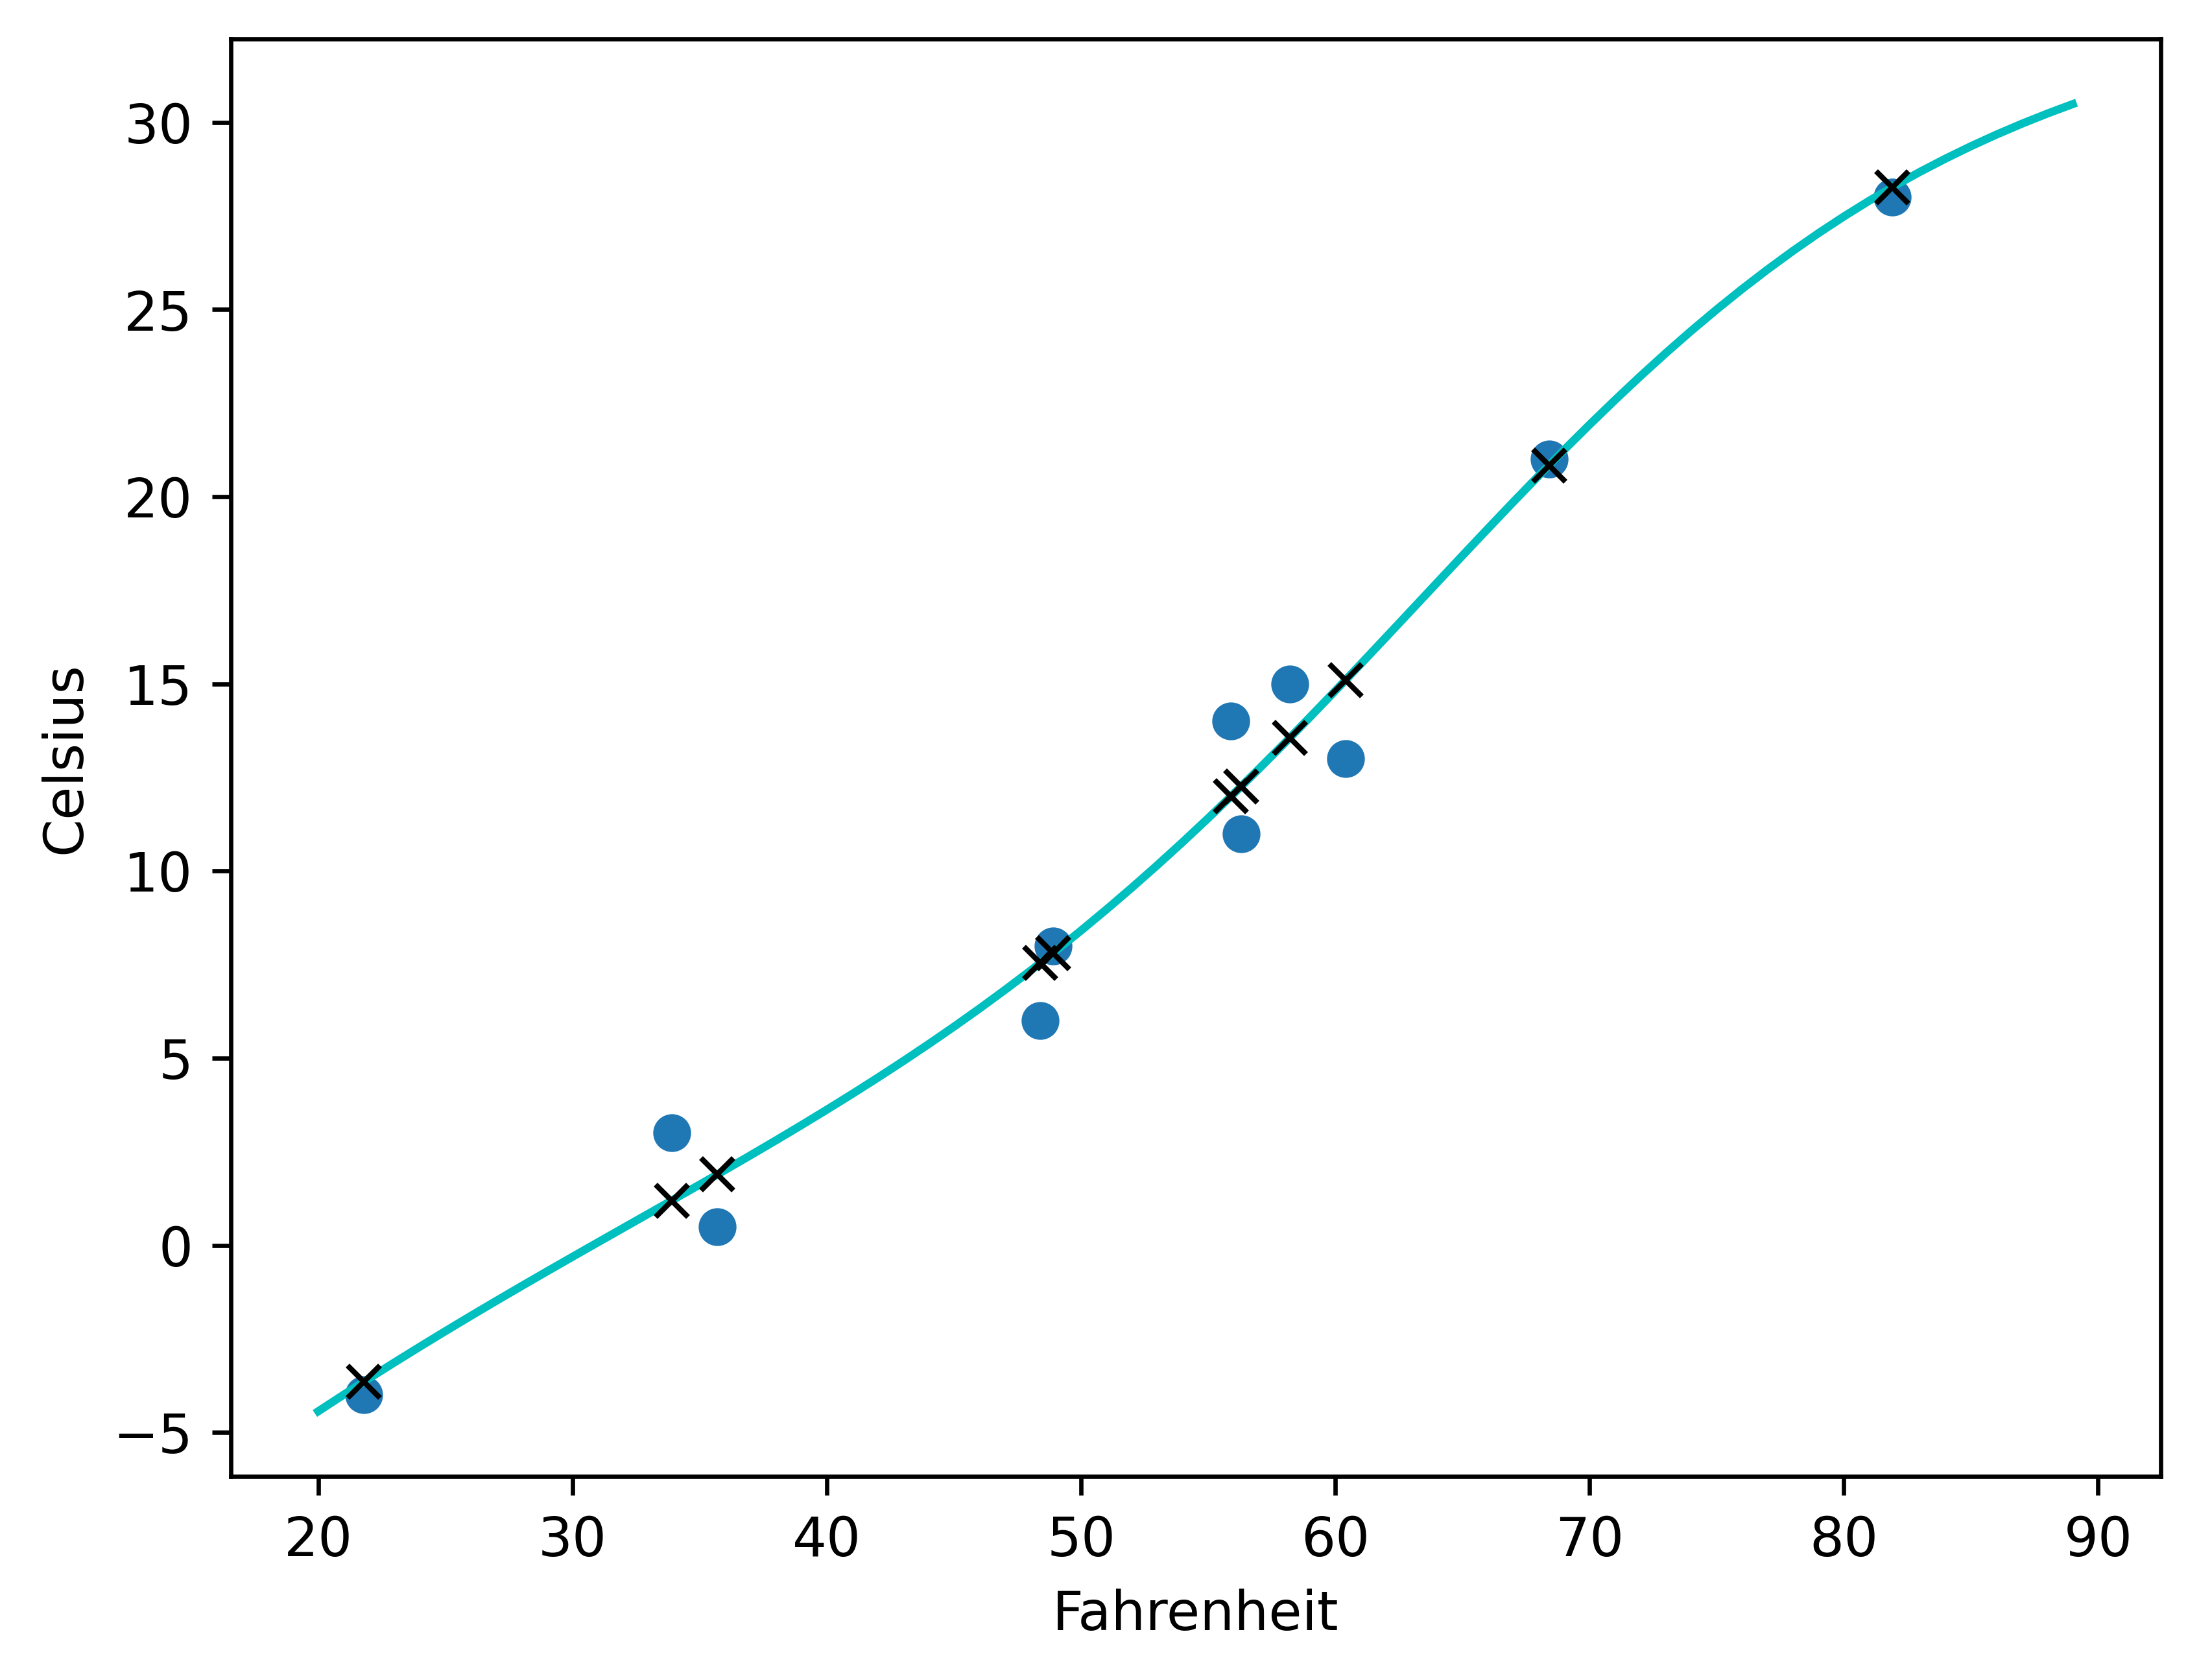

In [20]:
from matplotlib import pyplot as plt

t_range = torch.arange(0., 50.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

最终的结果如上图，从中可以看到神经网络由过拟合的倾向，它试图跟踪测量值，包括有噪声的测量值，即使这个神经网络很小，但还是有太多的参数来适应仅有的几个测量值，不过总的来说它做的还不错。